<a href="https://colab.research.google.com/github/cc-ats/mlp_class/blob/main/Lesson1_FNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fitting Neural Network Models

In this tutorial, we will learn how to use a neural network model to predict the energy of points on the Müller-Brown potential energy surface. 



## Defining the Müller-Brown Potential Energy Function

For the definition of Müller-Brown potential, see [here](https://www.wolframcloud.com/objects/demonstrations/TrajectoriesOnTheMullerBrownPotentialEnergySurface-source.nb).

$v(x,y) = \sum_{k=0}^3 A_k \mathrm{exp}\left[ a_k (x - x_k^0)^2 + b_k (x - x_k^0) (y - y_k^0) + c_k (y - y_k^0)^2 \right] $

In [ ]:
from math import exp, pow

def mueller_brown_potential(x, y):
    A = [-200, -100, -170, 15]
    a = [-1, -1, -6.5, 0.7]
    b = [0, 0, 11, 0.6]
    c = [-10, -10, -6.5, 0.7]
    x0 = [1, 0, -0.5, -1.0]
    y0 = [0, 0.5, 1.5, 1]
    z = 0
    for k in range(4):
        # Scale the function by 0.1 to make plotting easier
        z += 0.1 * A[k] * exp(a[k] * pow(x-x0[k], 2) + b[k] * (x-x0[k]) * (y-y0[k]) + c[k] * pow(y-y0[k], 2))
    return z

### Generate Training Data

First, we need to generate data to train the neural network.


In [ ]:
import numpy as np

# generate x and y  on a grid
x_range = np.arange(-1.8, 1.4, 0.1, dtype=np.float32)
y_range = np.arange(-0.4, 2.4, 0.1, dtype=np.float32)
X, Y = np.meshgrid(x_range, y_range)

# compute the potential energy at each point on the grid
mueller_brown_potential_vectorized = np.vectorize(mueller_brown_potential, otypes=[np.float32])
Z = mueller_brown_potential_vectorized(X, Y)

# keep only low-energy points for training
train_mask = Z < 10
X_train, Y_train, Z_train = X[train_mask], Y[train_mask], Z[train_mask]

print(f"Z_min: {np.min(Z)}, Z_max: {np.max(Z)}")
print(f"Size of (future) training set: {len(Z_train)}")

### Visualizing Training Data: 3-D Projection Surface

We will now create a 3-D plot of our training data. We are going to use the `plotly` library to create an interactive plot. We only plot the part of the potential energy surface that is below 15 (arbitrary unit). For the actual training, only the part that is below 10 (arbitrary unit) will be used.

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y, colorscale='rainbow', cmin=-15, cmax=9)])
fig.update_traces(contours_z=dict(show=True, project_z=True))
fig.update_layout(title='Mueller-Brown Potential', width=500, height=500,
                  scene = dict(
                      zaxis = dict(dtick=3, range=[-15, 15]),
                      camera_eye = dict(x=-1.2, y=-1.2, z=1.2)))

### Visualizing Training Data: Contour Surface

Now we will create a contour surface plot of our training data. Since we will plot similar contour surface plots later, we will define a function to do this.

In [ ]:
import matplotlib.pyplot as plt

def plot_contour_map(X, Y, Z, ax, title, colorscale='rainbow', levels=None):
    if levels is None:
        levels = [-12, -8, -4, 0, 4, 8, 10]
    ct = ax.contour(X, Y, Z, levels, colors='k')
    ax.clabel(ct, inline=True, fmt='%3.0f', fontsize=8)
    ct = ax.contourf(X, Y, Z, levels, cmap=colorscale, extend='both', vmin=levels[0], vmax=levels[-1])
    ax.set_xlabel("x", labelpad=-0.75)
    ax.set_ylabel("y", labelpad=2.5)
    ax.tick_params(axis='both', pad=2, labelsize=8)
    cbar = plt.colorbar(ct)
    cbar.ax.tick_params(labelsize=8)
    ax.set_title(title, fontsize=8)


fig, ax = plt.subplots(figsize=(3, 2.5), dpi=150)
plot_contour_map(X, Y, Z, ax=ax, title='Mueller-Brown Potential')
fig.tight_layout()

## Defining the Neural Network Class

### A Basic Neural Network 

Below is a schematic of a neural network. Inputs ($x$, $y$) are given weights ($w$). For each neuron in the hidden layer a bias ($b$) is added to the weighted inputs to generate a value ($v$) for the activation function (tanh). The activation function decides the activity ($v'$) of each neuron in the hidden layer. Weights ($w'$), biases ($b'$), and the activation function on the neuron of the output layer produces the prediction ($V^{pred}$). 

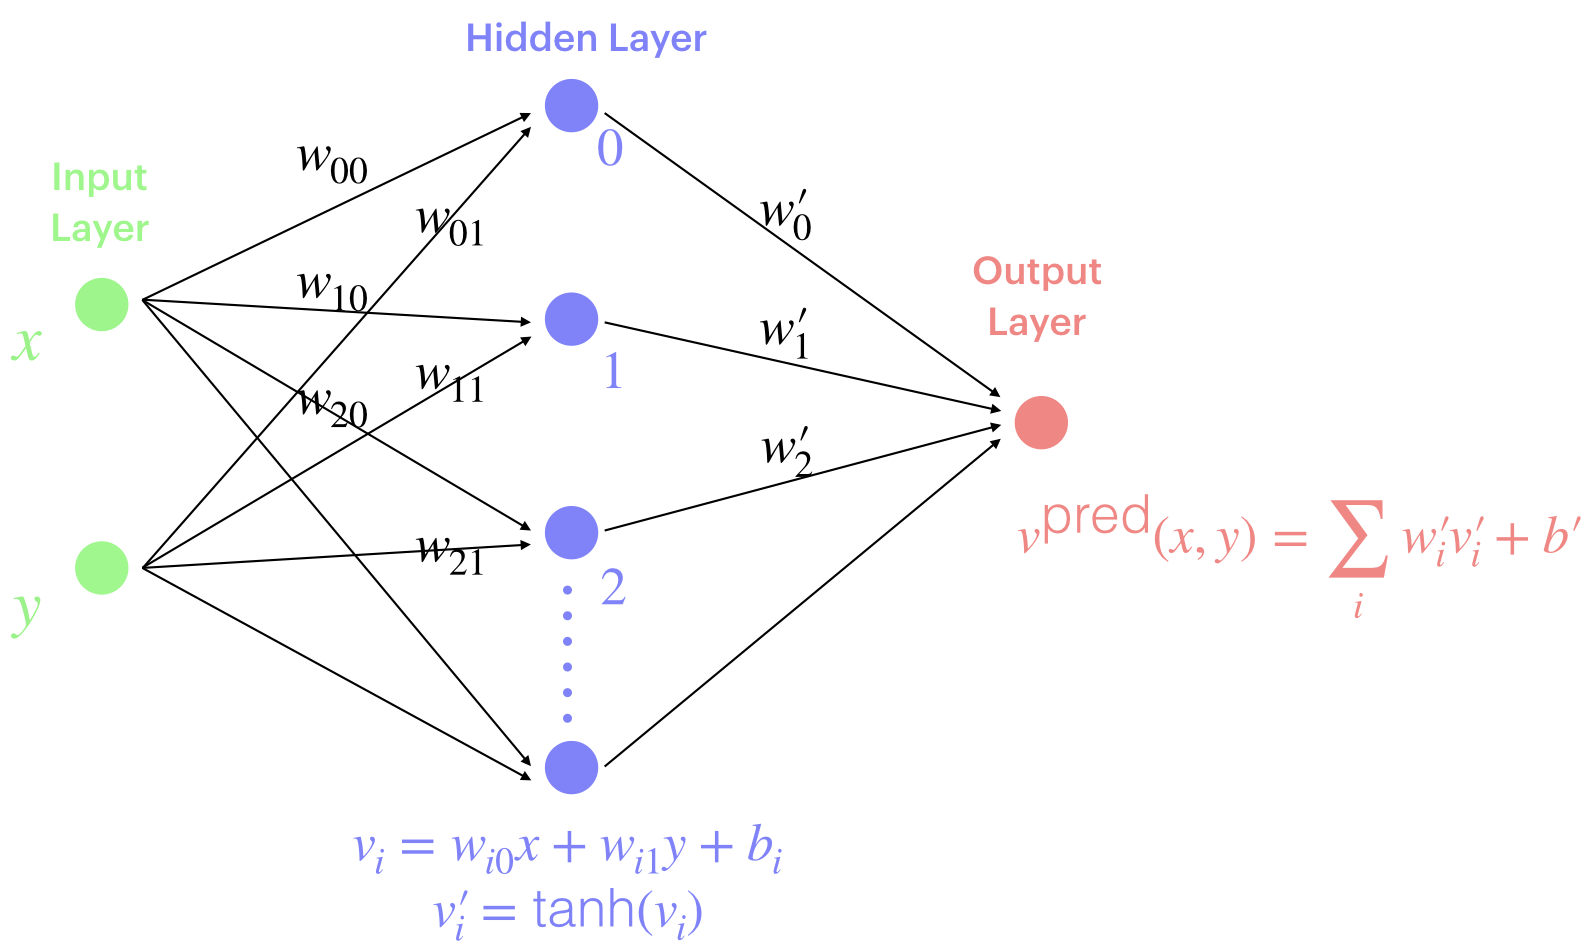

Here we define our neural network as a Python class. A function ($\it{train\_loop}$) is used to loop through our training data.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Set default data type to float32
torch.set_default_dtype(torch.float32)


class NeuralNetwork(nn.Module):
    def __init__(self, n_hidden=20):
        """
        Args:
            n_hidden (int): Number of neurons in the hidden layer.
        """
        super().__init__()
        self.linear = nn.Sequential(
            nn.Linear(2, n_hidden), # Linear function taking 2 inputs and outputs data for n_hidden neurons.
            nn.Tanh(),
            nn.Linear(n_hidden, 1) # Linear function taking data from n_hidden neurons and producing one output value. 
        )

    def forward(self, x): 
        return self.linear(x)


def train_loop(dataloader, model, loss_fn, optimizer):
    model.train() # Set model to training mode.
    num_batches = len(dataloader)
    train_loss = 0
    for X, y in dataloader:
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred.squeeze(), y)

        # Backpropagation - using the loss function gradients to update the weights and biases.
        optimizer.zero_grad() # Zero out the gradients from the previous iteration to replace them. 
        loss.backward() # Update the gradients of the loss function.
        optimizer.step() # Uses step() to optimize the weights and biases with the updated gradients. 

        with torch.no_grad():
            train_loss += loss.item()

    train_loss /= num_batches
    return train_loss

## Loading PyTorch and Training Data

After installing and importing pytorch, we will save our training data as a tensor data set.

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

# turn NumPy arrays into PyTorch tensors
X_tensor = torch.from_numpy(np.column_stack((X_train, Y_train)))
Y_tensor = torch.from_numpy(Z_train)

dataset = TensorDataset(X_tensor, Y_tensor)
print(f"Size of training set: {len(dataset)}")

## Training the Model

Now we can train the neural network model. We will finish our training when the desired number of epochs has been reached. We will also define some terms used for training below.

Epochs - Number of forward/backward passes through the entire neural network. 

Learning Rate - Determines the step size as we try to minimize the loss function. A faster learning rate would have a larger step size.

Stochastic Gradient Descent (SGD) - The algorithm used for minimizing the loss function.

Note: In this example, there are 696 training points broken into 87 batches of batch size 8.

In [ ]:
# Set random seed for reproducibility
torch.manual_seed(314)

# Hyperparameters
batch_size = 32
epochs = 1000
learning_rate = 1e-2
n_hidden = 20

train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
model = NeuralNetwork(n_hidden)
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

print("Training Errors:")
for epoch in range(epochs):
    train_loss = train_loop(train_loader, model, loss_fn, optimizer)
    if (epoch + 1) % 100 == 0:
        print(f"epoch: {epoch:>3d}   loss: {train_loss:>6.3f}")
print("Done with Training!")

## Plotting Reference, Predicted, and Difference Surfaces

Finally, we will plot the Müller-Brown potential energy surface using the analytical function (reference), using the neural network (predicted), and we will show the difference between the predicted and reference surfaces.

In [ ]:
model.eval() # Set model to evaluation mode
Z_pred = model(torch.from_numpy(np.column_stack((X.flatten(), Y.flatten())))).detach().numpy().reshape(Z.shape)
Z_diff = Z_pred - Z

fig, ax = plt.subplots(3, figsize=(3, 7.5), dpi=150)
plot_contour_map(X, Y, Z, ax=ax[0], title='(a) Reference')
plot_contour_map(X, Y, Z_pred, ax=ax[1], title='(b) Predicted')
plot_contour_map(X, Y, Z_diff, ax=ax[2], title='(c) Difference', levels=[-4, -2, 0, 2, 4])
fig.tight_layout()

## Taking a Look at the NN parameters

In order to take a closer look at the neural network parameters, we will plug them into the linear functions.

In [ ]:
print("model:", model)

for name, param in model.named_parameters():
    if name == 'linear.0.weight': weights0 = param.data.detach().numpy()
    elif name == 'linear.0.bias': bias0 = param.data.detach().numpy()
    elif name == 'linear.2.weight': weights2 = param.data.detach().numpy()
    elif name == 'linear.2.bias': bias2 = param.data.detach().numpy()

xy0 = torch.tensor([-0.5, 1.5], dtype=torch.float32)
z0 = model(xy0)

#first linear function
v1 = np.zeros(n_hidden)
for i in range(n_hidden):
    v1[i] += weights0[i, 0] * xy0[0] + weights0[i, 1] * xy0[1] + bias0[i]

#activation function
v2 = np.zeros(n_hidden)
for i in range(n_hidden):
    v2[i] = np.tanh(v1[i])

#second linear function
z_pred = 0.0
for i in range(n_hidden):
    z_pred += weights2[0,i] * v2[i]
z_pred += bias2[0]

print("z0:", z0, "z_pred:", z_pred)

## A More Automated/Refined Implementation

### A PyTorch-Lightning Implementation

Below is a more professional implementation of the neural network that saves epoch infromation in the logs_csv/ directory.

In [ ]:
%pip install lightning --quiet
import lightning.pytorch as pl
from lightning.pytorch.loggers import CSVLogger

In [ ]:
class NeuralNetworkLightning(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self.model(x)
        loss = F.mse_loss(y_pred.squeeze(), y)
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        # Using the Adam optimzation algorithm instead of SGD. 
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return [optimizer]


In [ ]:
%%capture
# Set random seed for reproducibility
pl.seed_everything(314, workers=True);

# Hyperparameters
batch_size = 32
epochs = 1000
learning_rate = 1e-2
n_hidden = 20

train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
csv_logger = CSVLogger('logs_csv', version=0)
trainer = pl.Trainer(max_epochs=epochs, logger=csv_logger, deterministic=True)
model = NeuralNetworkLightning(NeuralNetwork(n_hidden), learning_rate)
trainer.fit(model, train_loader)

### Plotting Training Error

Now we can plot the training error as the number of epochs increases.


In [ ]:
import pandas as pd
loss = pd.read_csv("logs_csv/lightning_logs/version_0/metrics.csv")

fig, ax = plt.subplots()
ax.semilogy(loss["epoch"], loss["train_loss"])
ax.set_xlabel("Epoch")
ax.set_ylabel("Training Errors")


### Plotting Reference, Predicted, and Difference Surfaces

Again, we plot the reference, predicted, and difference surfaces using the more refined neural network implementation.


In [ ]:
model.eval() # Set model to evaluation mode
Z_pred = model(torch.from_numpy(np.column_stack((X.flatten(), Y.flatten())))).detach().numpy().reshape(Z.shape)
Z_diff = Z_pred - Z

fig, ax = plt.subplots(3, figsize=(3, 7.5), dpi=150)
plot_contour_map(X, Y, Z, ax=ax[0], title='(a) Reference')
plot_contour_map(X, Y, Z_pred, ax=ax[1], title='(b) Predicted')
plot_contour_map(X, Y, Z_diff, ax=ax[2], title='(c) Difference', levels=[-4, -2, 0, 2, 4])
fig.tight_layout()

## Train with Energy and Gradient

In [ ]:
def mueller_brown_potential_gradient(x, y):
    A = [-200, -100, -170, 15]
    a = [-1, -1, -6.5, 0.7]
    b = [0, 0, 11, 0.6]
    c = [-10, -10, -6.5, 0.7]
    x0 = [1, 0, -0.5, -1.0]
    y0 = [0, 0.5, 1.5, 1]
    dx = 0
    dy = 0
    for k in range(4):
        dx += 0.1 * A[k] * exp(a[k] * pow(x-x0[k], 2) + b[k] * (x-x0[k]) * (y-y0[k]) + c[k] * pow(y-y0[k], 2)) * (a[k] * 2 *(x-x0[k]) + b[k] * (y-y0[k]))
        dy += 0.1 * A[k] * exp(a[k] * pow(x-x0[k], 2) + b[k] * (x-x0[k]) * (y-y0[k]) + c[k] * pow(y-y0[k], 2)) * (b[k] * (x-x0[k])+ c[k] * 2 * (y-y0[k]))
    return dx, dy

In [ ]:
# compute the potential energy gradient at each point on the grid
mueller_brown_potential_gradient_vectorized = np.vectorize(mueller_brown_potential_gradient, otypes=[np.float32, np.float32])
dX, dY = mueller_brown_potential_gradient_vectorized(X, Y)

# keep only low-energy points for training
dX_train, dY_train = dX[train_mask], dY[train_mask]

dX_tensor = torch.from_numpy(np.column_stack((dX_train, dY_train)))
dataset = TensorDataset(X_tensor, Y_tensor, dX_tensor)

In [ ]:
def train_loop_with_gradient(dataloader, model, loss_fn, optimizer):
    model.train() # Set model to training mode.
    num_batches = len(dataloader)
    train_loss = 0
    train_loss_energy = 0
    train_loss_gradient = 0
    for X, y, dX in dataloader:
        # Compute prediction and loss
        y_pred = model(X)
        dX_pred = torch.autograd.grad(y_pred, X, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]
        loss_energy = loss_fn(y_pred.squeeze(), y)
        loss_gradient = loss_fn(dX_pred.squeeze(), dX)
        loss = loss_energy + loss_gradient

        # Backpropagation - using the loss function gradients to update the weights and biases.
        optimizer.zero_grad() # Zero out the gradients from the previous iteration to replace them. 
        loss.backward() # Update the gradients of the loss function.
        optimizer.step() # Uses step() to optimize the weights and biases with the updated gradients. 

        with torch.no_grad():
            train_loss += loss.item()
            train_loss_energy += loss_energy.item()
            train_loss_gradient += loss_gradient.item()

    train_loss /= num_batches
    train_loss_energy /= num_batches
    train_loss_gradient /= num_batches
    return train_loss, train_loss_energy, train_loss_gradient

In [ ]:
# Set random seed for reproducibility
torch.manual_seed(314)

# Hyperparameters
batch_size = 32
epochs = 1000
learning_rate = 1e-3
n_hidden = 20

train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
model = NeuralNetwork(n_hidden)
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

print("Training errors:")
for epoch in range(epochs):
    X_tensor.requires_grad_(True)
    train_loss, train_loss_energy, train_loss_gradient = train_loop_with_gradient(train_loader, model, loss_fn, optimizer)
    if (epoch + 1) % 100 == 0:
        print(f"epoch: {epoch:>3d}   loss: {train_loss:>6.3f}   energy loss: {train_loss_energy:>6.3f}   gradient loss: {train_loss_gradient:>6.3f}")
print("Done with Training!")

In [ ]:
model.eval() # Set model to evaluation mode
Z_pred = model(torch.from_numpy(np.column_stack((X.flatten(), Y.flatten())))).detach().numpy().reshape(Z.shape)
Z_diff = Z_pred - Z

fig, ax = plt.subplots(3, figsize=(3, 7.5), dpi=150)
plot_contour_map(X, Y, Z, ax=ax[0], title='(a) Reference')
plot_contour_map(X, Y, Z_pred, ax=ax[1], title='(b) Predicted')
plot_contour_map(X, Y, Z_diff, ax=ax[2], title='(c) Difference', levels=[-4, -2, 0, 2, 4])
fig.tight_layout()